<a href="https://colab.research.google.com/github/saqlineniam/Strawberry/blob/main/RF_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, make_scorer
import statsmodels.api as sm
import os
from sklearn.inspection import permutation_importance
import joblib
from collections import defaultdict
from sklearn.model_selection import RepeatedKFold, cross_validate

In [3]:
df = pd.read_excel(r"Df.xlsx")

In [4]:
x = df.iloc[:,2:6]
y = df.iloc[:, 6:11]

In [5]:
print(x.head())
print(y.head())

   Days  Alginate  Guargum  Pectin
0     2       0.0      0.0     0.0
1     2       3.0      0.0     0.0
2     2       0.0      3.0     0.0
3     2       0.0      0.0     3.0
4     2       1.5      1.5     0.0
   WeightLoss  Firmness  TSS    pH        ΔE
0       14.69    468.69  4.6  4.11  9.398904
1        8.54    457.32  5.9  4.07  7.734145
2        9.03    509.90  5.8  4.08  7.604591
3        8.59    588.24  6.1  4.14  5.112592
4        7.69    682.79  6.4  4.05  2.631045


In [6]:
n_targets = ['WeightLoss', 'Firmness', 'TSS', 'pH', 'ΔE']

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=21)

In [8]:
y_train_arr  = Y_train.to_numpy()

In [9]:
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=21)

In [10]:
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", MultiOutputRegressor(
        RandomForestRegressor(
            random_state=21,
            n_jobs=-1
        )
    ))
])

In [11]:
param_grid_rf = {
    # Number of trees
    "reg__estimator__n_estimators":      [50, 100, 200],

    # Maximum tree depth: None = grow until leaves are pure
    "reg__estimator__max_depth":         [None, 5, 10],

    # Minimum samples to split an internal node
    "reg__estimator__min_samples_split": [2, 5, 10],

    # Minimum samples to be at a leaf node
    "reg__estimator__min_samples_leaf":  [1, 2, 4],

    # Number of features considered at each split
    "reg__estimator__max_features":      ["auto", "sqrt", "log2"]
}


In [13]:
# === 5. GridSearchCV on the training set ===
grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    scoring="neg_root_mean_squared_error",
    cv=cv,              # 5-fold CV on training data
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train, Y_train)

print("Best hyperparameters:", grid_rf.best_params_)
print("Best CV neg-RMSE:", grid_rf.best_score_)

Fitting 20 folds for each of 243 candidates, totalling 4860 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
832 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y,

Best hyperparameters: {'reg__estimator__max_depth': None, 'reg__estimator__max_features': 'sqrt', 'reg__estimator__min_samples_leaf': 1, 'reg__estimator__min_samples_split': 2, 'reg__estimator__n_estimators': 200}
Best CV neg-RMSE: -6.946928206314344


In [14]:
# === 6. Predict on train & test ===
best_model = grid_rf.best_estimator_

Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

In [15]:
joblib.dump(best_model, "best_rf_pipeline.pkl")

['best_rf_pipeline.pkl']

In [16]:
# Convert predictions to DataFrames with the same columns as Y_train
Y_train_pred_df = pd.DataFrame(Y_train_pred, columns=Y_train.columns, index=Y_train.index)
Y_test_pred_df  = pd.DataFrame(Y_test_pred,  columns=Y_test.columns,  index=Y_test.index)

In [17]:
metrics = []
for col in Y_train.columns:
    true_tr = Y_train[col]
    pred_tr = Y_train_pred_df[col]
    true_te = Y_test[col]
    pred_te = Y_test_pred_df[col]

    # Compute RMSE via sqrt of MSE
    train_rmse = np.sqrt(mean_squared_error(true_tr, pred_tr))
    test_rmse  = np.sqrt(mean_squared_error(true_te,  pred_te))

    train_mae = mean_absolute_error(true_tr, pred_tr)
    test_mae  = mean_absolute_error(true_te,  pred_te)

    train_r2  = r2_score(true_tr, pred_tr)
    test_r2   = r2_score(true_te,  pred_te)

    metrics.append({
        "target":     col,
        "train_RMSE": train_rmse,
        "test_RMSE":  test_rmse,
        "train_MAE":  train_mae,
        "test_MAE":   test_mae,
        "train_R2":   train_r2,
        "test_R2":    test_r2
    })

# Build and show DataFrame
metrics_df = pd.DataFrame(metrics).set_index("target")
print(metrics_df)
metrics_df.to_excel("RF_model_performance_metrics.xlsx", index=True)

            train_RMSE  test_RMSE  train_MAE   test_MAE  train_R2   test_R2
target                                                                     
WeightLoss    0.568587   0.750932   0.427616   0.644931  0.993497  0.989596
Firmness     14.026337  16.415017   9.584628  13.738443  0.991005  0.987847
TSS           0.285341   0.468611   0.176388   0.290878  0.959869  0.892052
pH            0.034598   0.078278   0.027569   0.051354  0.951957  0.812869
ΔE            0.984639   1.365039   0.691136   1.031498  0.953291  0.897564


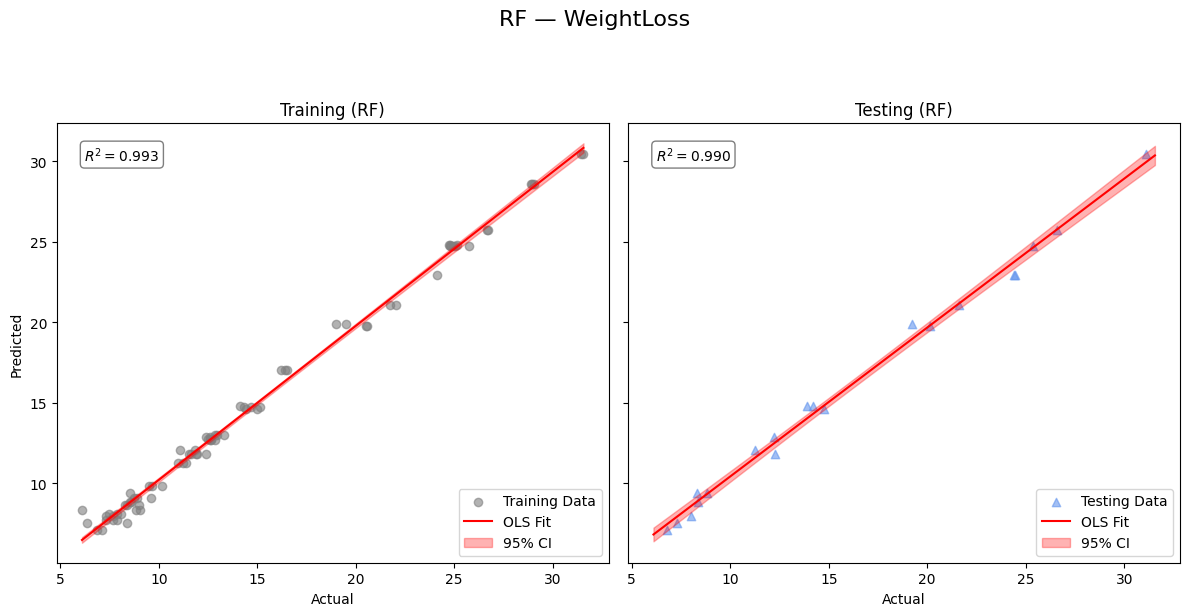

Saved RF plot to RF_comparison_plots/RF_actual_vs_pred_WeightLoss.png


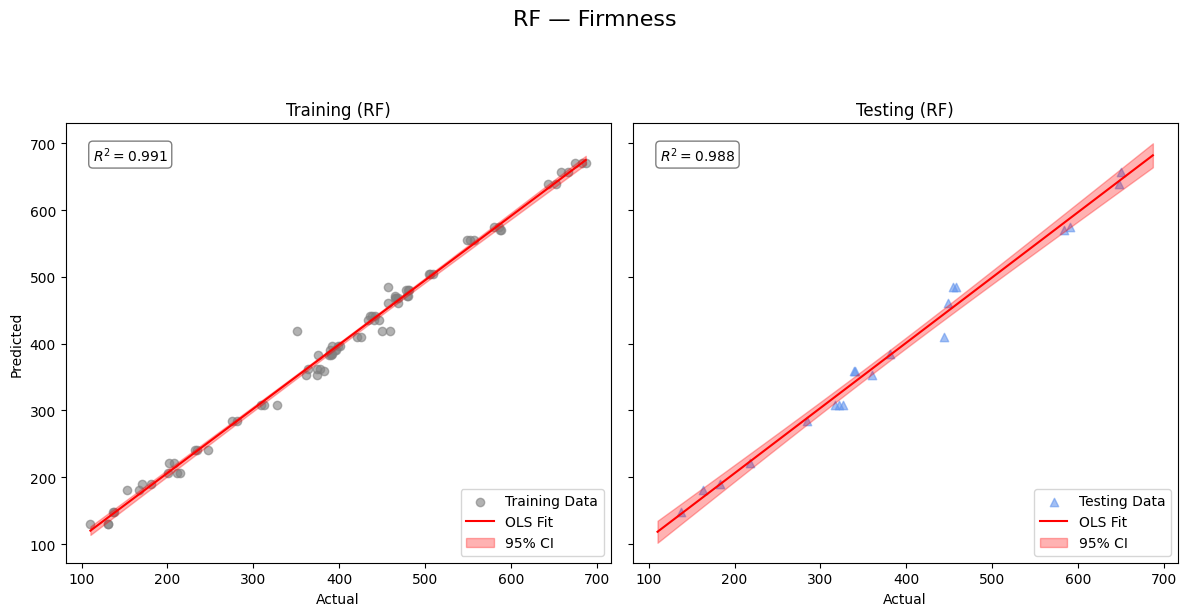

Saved RF plot to RF_comparison_plots/RF_actual_vs_pred_Firmness.png


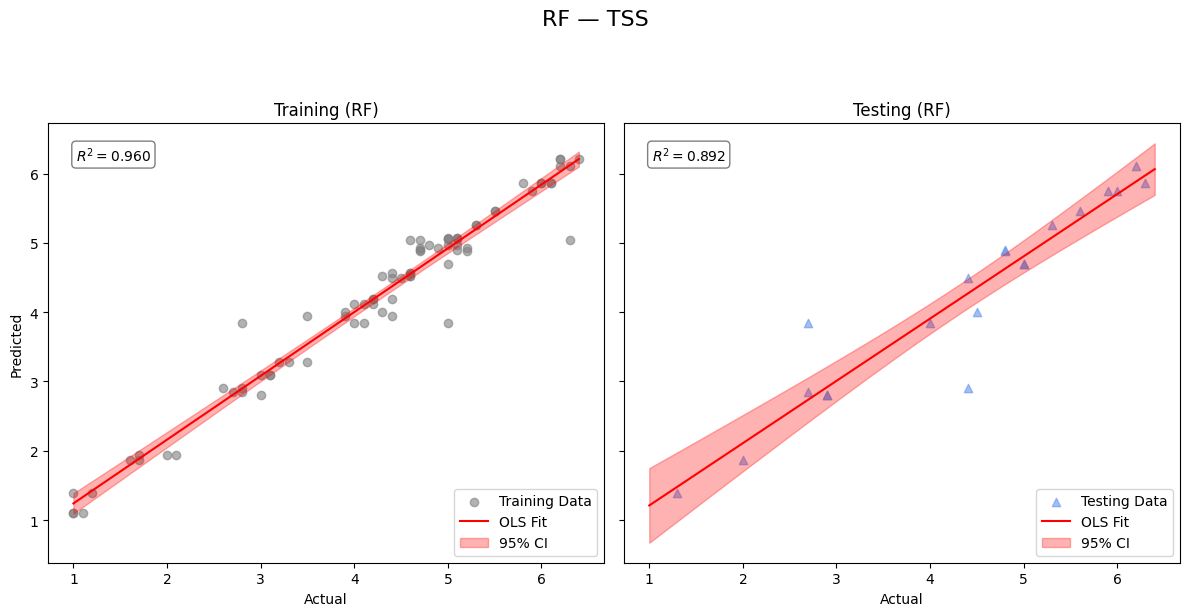

Saved RF plot to RF_comparison_plots/RF_actual_vs_pred_TSS.png


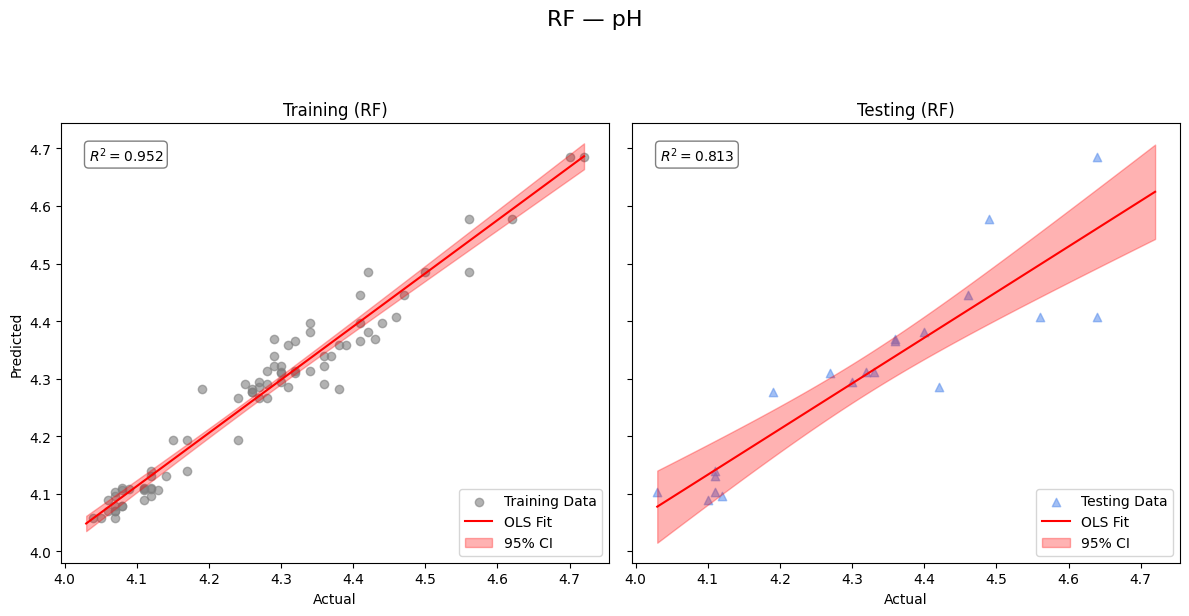

Saved RF plot to RF_comparison_plots/RF_actual_vs_pred_pH.png


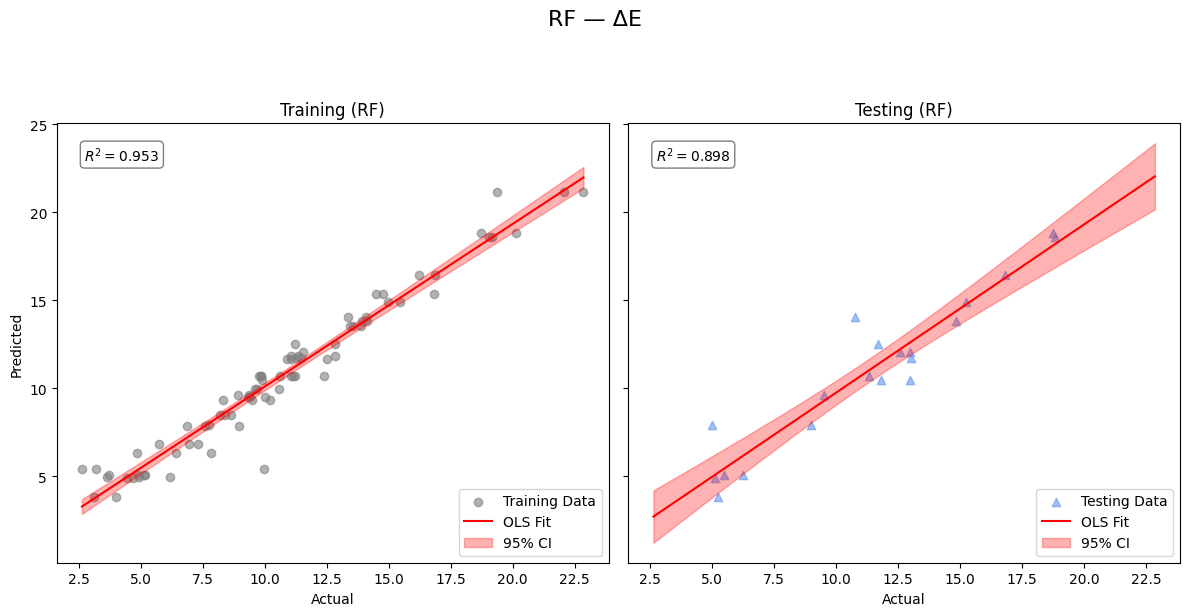

Saved RF plot to RF_comparison_plots/RF_actual_vs_pred_ΔE.png


In [18]:
# 2) Create output folder
os.makedirs("RF_comparison_plots", exist_ok=True)

# 3) Loop over each target
for target in Y_train.columns:
    y_tr = Y_train[target].values
    yp_tr = Y_train_pred_df[target].values
    y_te = Y_test[target].values
    yp_te = Y_test_pred_df[target].values

    # Compute R²
    r2_tr = r2_score(y_tr, yp_tr)
    r2_te = r2_score(y_te, yp_te)

    # Range for plotting the regression line & CI
    mn, mx = min(y_tr.min(), y_te.min()), max(y_tr.max(), y_te.max())
    xg = np.linspace(mn, mx, 100)

    # Fit OLS on train
    ols_tr = sm.OLS(yp_tr, sm.add_constant(y_tr)).fit()
    ci_tr = ols_tr.get_prediction(sm.add_constant(xg)).summary_frame(alpha=0.05)
    # Fit OLS on test
    ols_te = sm.OLS(yp_te, sm.add_constant(y_te)).fit()
    ci_te = ols_te.get_prediction(sm.add_constant(xg)).summary_frame(alpha=0.05)

    # 4) Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    # TRAINING panel
    ax1.scatter(y_tr, yp_tr, color='gray', alpha=0.6, label="Training Data")
    ax1.plot(xg, ci_tr['mean'], color='red', label="OLS Fit")
    ax1.fill_between(xg, ci_tr['mean_ci_lower'], ci_tr['mean_ci_upper'],
                     color='red', alpha=0.3, label="95% CI")
    ax1.text(0.05, 0.95, f'$R^2={r2_tr:.3f}$', transform=ax1.transAxes,
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3',
             fc='white', ec='black', alpha=0.5))
    ax1.set_title("Training (RF)")
    ax1.set_xlabel("Actual")
    ax1.set_ylabel("Predicted")
    ax1.legend(loc='lower right')

    # TESTING panel
    ax2.scatter(y_te, yp_te, color='cornflowerblue', marker='^', alpha=0.6, label="Testing Data")
    ax2.plot(xg, ci_te['mean'], color='red', label="OLS Fit")
    ax2.fill_between(xg, ci_te['mean_ci_lower'], ci_te['mean_ci_upper'],
                     color='red', alpha=0.3, label="95% CI")
    ax2.text(0.05, 0.95, f'$R^2={r2_te:.3f}$', transform=ax2.transAxes,
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3',
             fc='white', ec='black', alpha=0.5))
    ax2.set_title("Testing (RF)")
    ax2.set_xlabel("Actual")
    ax2.legend(loc='lower right')

    # Super title & layout
    fig.suptitle(f"RF — {target}", y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Save to file
    fname = f"RF_actual_vs_pred_{target.replace(' ', '_')}.png"
    fig.savefig(os.path.join("RF_comparison_plots", fname), dpi=300, bbox_inches="tight")
    plt.close(fig)
    plt.show()
    print(f"Saved RF plot to RF_comparison_plots/{fname}")

In [19]:
def summarize(name, Y_true, Y_pred):
    # compute RMSE explicitly
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mae  = mean_absolute_error(Y_true, Y_pred)
    r2   = r2_score(Y_true, Y_pred)
    print(f"{name} → RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

# after GridSearchCV and best_model.predict:
Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

summarize("Train", Y_train, Y_train_pred)
summarize("Test",  Y_test,  Y_test_pred)

Train → RMSE: 6.295, MAE: 2.181, R²: 0.970
Test → RMSE: 7.377, MAE: 3.151, R²: 0.916


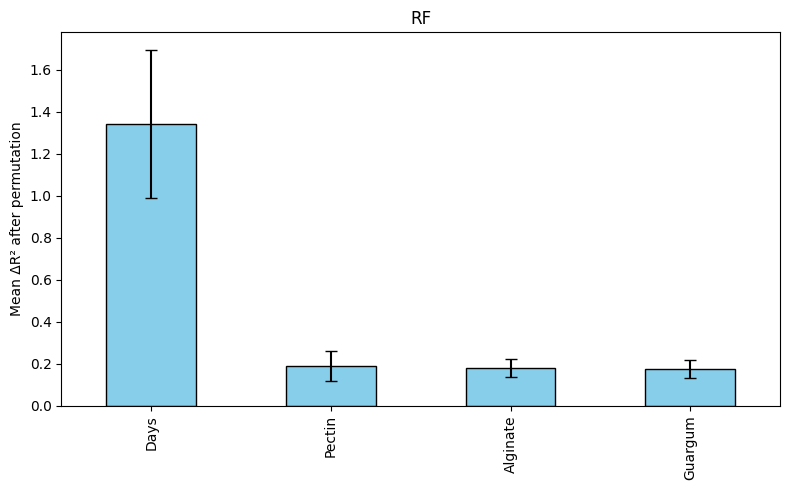

In [22]:
# 1) Define an averaged‐R² scorer across all outputs
def avg_r2(y_true, y_pred):
    # multioutput='raw_values' returns one R2 per target
    return np.mean(r2_score(y_true, y_pred, multioutput='raw_values'))

r2_scorer = make_scorer(avg_r2)

# 2) Compute permutation importances on the test set
# best_model is your trained Pipeline (with scaler + MultiOutputRegressor)
# X_test, Y_test are your hold‐out sets (arrays or DataFrames)
res = permutation_importance(
    best_model, X_test, Y_test,
    scoring=r2_scorer,
    n_repeats=30,      # more repeats → smoother estimates
    random_state=0,
    n_jobs=-1
)

# 3) Aggregate into a pandas Series
# If X_test is a DataFrame, use its columns; otherwise supply a list of names
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"X{i}" for i in range(X_test.shape[1])]
importances = pd.Series(res.importances_mean, index=feature_names)
stds        = pd.Series(res.importances_std,  index=feature_names)

# 4) Sort descending
importances = importances.sort_values(ascending=False)
stds        = stds.loc[importances.index]

# 5) Plot
plt.figure(figsize=(8,5))
importances.plot.bar(yerr=stds, capsize=4, color='skyblue', edgecolor='k')
plt.ylabel("Mean ΔR² after permutation")
plt.title("RF")
plt.tight_layout()
plt.savefig("RF_permutation_feature_importance.png", dpi=300)
plt.show()